# 🌦️ WeatherWise – Starter Notebook

Welcome to your **WeatherWise** project notebook! This scaffold is designed to help you build your weather advisor app using Python, visualisations, and AI-enhanced development.

---

📄 **Full Assignment Specification**  
See [`ASSIGNMENT.md`](ASSIGNMENT.md) or check the LMS for full details.

📝 **Quick Refresher**  
A one-page summary is available in [`resources/assignment-summary.md`](resources/assignment-summary.md).

---

🧠 **This Notebook Structure is Optional**  
You’re encouraged to reorganise, rename sections, or remove scaffold cells if you prefer — as long as your final version meets the requirements.

✅ You may delete this note before submission.



## 🧰 Setup and Imports

This section imports commonly used packages and installs any additional tools used in the project.

- You may not need all of these unless you're using specific features (e.g. visualisations, advanced prompting).
- The notebook assumes the following packages are **pre-installed** in the provided environment or installable via pip:
  - `requests`, `matplotlib`, `pyinputplus`
  - `fetch-my-weather` (for accessing weather data easily)
  - `hands-on-ai` (for AI logging, comparisons, or prompting tools)

If you're running this notebook in **Google Colab**, uncomment the following lines to install the required packages.


In [5]:
# 🧪 Optional packages — uncomment if needed in Colab or JupyterHub
!pip install fetch-my-weather
!pip install hands-on-ai
!pip install pyinputplus


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyinputplus: filename=pyinputplus-0.2.12-py3-none-any.whl size=11348 sha256=78d39804518b7f10e19c67769b0c7c1db330043caf501890474a4cf3e6d15b5b
  Stored in directory: /root/.cache/pip/wheels/85/81/c1/325c8199c5c4de8a0b9af900ff9cd8bd69853e3d9419493512
  Created wheel for pysimplevalidate: filename=pysimplevalidate-0.2.12-py3-none-any.whl size=16225 sha256=dedd210bcba2d6f40893690f446ea8404ac453ff55bb762254ee4256d875248c
  Stored in directory: /root/.cache/pip/wheels/09/de/18/4dd2be0dbdf31870c6f0abde43b0de197b1c095655ad7da5c2
  Created wheel for stdiomask: filename=stdiomask

In [6]:
import os

os.environ['HANDS_ON_AI_SERVER'] = 'http://ollama.serveur.au'
os.environ['HANDS_ON_AI_MODEL'] = 'granite3.2'
os.environ['HANDS_ON_AI_API_KEY'] = input('Enter your API key: ')

Enter your API key: 12bd9993343147caaa39aee888a2fe78.Fs_XIQ-2RYf1bMLg-5wZUbad


## 📦 Setup and Configuration
Import required packages and setup environment.

In [7]:
import os
import re
import requests
import matplotlib.pyplot as plt
import pyinputplus as pyip
from datetime import datetime, timedelta
from fetch_my_weather import get_weather
from hands_on_ai.chat import get_response

# Optional: try to import the convenience package if available
try:
    from fetch_my_weather import get_weather as fetch_my_weather_get
    _HAS_FETCH_MY_WEATHER = True
except Exception:
    _HAS_FETCH_MY_WEATHER = False


def _safe_get(url, params=None, timeout=10):
    """Helper: perform requests.get with basic error handling."""
    try:
        r = requests.get(url, params=params, timeout=timeout)
        r.raise_for_status()
        return r
    except Exception as e:
        # Return None and let caller decide
        return None

## 🌤️ Weather Data Functions

In [8]:
def get_weather_data(location, forecast_days=5):
    """
    Retrieve weather data for a specified location.

    Args:
        location (str): City or location name
        forecast_days (int): Number of days to forecast (1-5)

    Returns:
        dict: Weather data including current conditions and forecast
              Structure:
              {
                "location": "<name>",
                "current": {"temp_C":..., "feelslike_C":..., "weather_desc": "...", "humidity": ..., "wind_kmph": ...},
                "forecast": [
                    {"date": "YYYY-MM-DD", "maxtemp_C":..., "mintemp_C":..., "avgtemp_C":..., "precip_chance_percent": ...},
                    ...
                ]
              }
    """
    forecast_days = min(max(int(forecast_days), 1), 5)

    # Try fetch-my-weather if available (foundation option)
    if _HAS_FETCH_MY_WEATHER:
        try:
            raw = fetch_my_weather_get(location)
            # Normalize based on observed structure from fetch-my-weather / wttr
            # Attempt to extract meaningful fields; fall back gracefully if missing.
            loc_name = raw.get("nearest_area", [{}])[0].get("areaName", [{}])[0].get("value", location)
            current = raw.get("current_condition", [{}])[0]
            forecast_raw = raw.get("weather", [])[:forecast_days]

            current_parsed = {
                "temp_C": float(current.get("temp_C", current.get("tempC", 0))),
                "feelslike_C": float(current.get("FeelsLikeC", current.get("feelslike_C", 0))),
                "weather_desc": (current.get("weatherDesc", [{}])[0].get("value", "")
                                 if isinstance(current.get("weatherDesc", ""), (list,tuple)) else current.get("weatherDesc","")),
                "humidity": int(current.get("humidity", 0)),
                "wind_kmph": float(current.get("windspeedKmph", current.get("wind_kmph", 0)))
            }

            forecast = []
            for day in forecast_raw:
                precip_list = [int(h.get("chanceofrain", 0)) for h in day.get("hourly", []) if "chanceofrain" in h]
                precip_chance = max(precip_list) if precip_list else int(day.get("hourly", [{}])[0].get("chanceofrain", 0))
                forecast.append({
                    "date": day.get("date"),
                    "maxtemp_C": float(day.get("maxtempC", day.get("maxTempC", 0))),
                    "mintemp_C": float(day.get("mintempC", day.get("minTempC", 0))),
                    "avgtemp_C": float(day.get("avgtempC", day.get("avgtempC", 0))),
                    "precip_chance_percent": int(precip_chance)
                })

            return {"location": loc_name, "current": current_parsed, "forecast": forecast}

        except Exception:
            # Fall through to wttr.in option
            pass

    # Standard option: use wttr.in JSON
    url = f"https://wttr.in/{location}"
    params = {"format": "j1"}
    resp = _safe_get(url, params=params)
    if resp is None:
        raise RuntimeError(f"Failed to fetch weather for: {location}")

    raw = resp.json()

    # Parse location name
    loc_name = location
    try:
        nearest = raw.get("nearest_area", [])
        if nearest:
            loc_name = nearest[0].get("areaName", [{}])[0].get("value", location)
    except Exception:
        pass

    # Current condition
    current = raw.get("current_condition", [{}])[0]
    current_parsed = {
        "temp_C": float(current.get("temp_C", current.get("tempC", 0))),
        "feelslike_C": float(current.get("FeelsLikeC", current.get("feelslikeC", 0))),
        "weather_desc": (current.get("weatherDesc", [{}])[0].get("value", "")
                         if isinstance(current.get("weatherDesc", ""), (list,tuple)) else current.get("weatherDesc","")),
        "humidity": int(current.get("humidity", 0)) if current.get("humidity") is not None else None,
        "wind_kmph": float(current.get("windspeedKmph", 0)) if current.get("windspeedKmph") else None
    }

    # Forecast: wttr 'weather' array contains daily entries with hourly info
    forecast = []
    weather_days = raw.get("weather", [])[:forecast_days]
    for day in weather_days:
        # Calculate maximum chance of rain from hourly if present
        hourly = day.get("hourly", [])
        precip_vals = []
        for h in hourly:
            # chanceofrain may be string
            val = h.get("chanceofrain") or h.get("chanceofrain", 0)
            try:
                precip_vals.append(int(val))
            except Exception:
                try:
                    precip_vals.append(int(float(val)))
                except Exception:
                    pass
        precip_chance = max(precip_vals) if precip_vals else 0

        forecast.append({
            "date": day.get("date"),
            "maxtemp_C": float(day.get("maxtempC", 0)),
            "mintemp_C": float(day.get("mintempC", 0)),
            "avgtemp_C": float(day.get("avgtempC", (float(day.get("maxtempC", 0)) + float(day.get("mintempC", 0))) / 2)),
            "precip_chance_percent": int(precip_chance)
        })

    return {"location": loc_name, "current": current_parsed, "forecast": forecast}

# ----------------------------
# Forecast day selection helper
# ----------------------------
def _select_forecast_day(parsed_question, weather_data):
    """
    Select relevant forecast day(s) based on parsed_question.
    Returns a list of forecast dicts.
    """
    forecast = weather_data.get("forecast", [])
    if not isinstance(forecast, list):
        forecast = forecast.get("forecastday", [])

    today = datetime.now().date()
    result = []

    time_filter = parsed_question.get("time", "any")
    n_days = parsed_question.get("n_days", 1)

    if time_filter == "today":
        for day in forecast:
            if day['date'] == today.strftime("%Y-%m-%d"):
                result.append(day)
                break
    elif time_filter == "tomorrow":
        tomorrow = today + timedelta(days=1)
        for day in forecast:
            if day['date'] == tomorrow.strftime("%Y-%m-%d"):
                result.append(day)
                break
    elif time_filter == "next_n_days" and n_days:
        for day in forecast[:n_days]:
            result.append(day)
    else:  # default: return full forecast
        result = forecast

    return result

## 📊 Visualisation Functions

In [9]:
import matplotlib.pyplot as plt

def create_temperature_visualisation(weather_data, output_type='display'):
    """
    Create visualisation of temperature data.
    Handles forecast returned as list or dict.
    """
    forecast = weather_data['forecast']
    # Fix: handle list vs dict
    if isinstance(forecast, list):
        forecast_days = forecast  # list of daily forecasts
    else:
        forecast_days = forecast.get('forecastday', [])

    dates = [day['date'] for day in forecast_days]
    max_temps = [day.get('maxtemp_C', day.get('maxtempC', 0)) for day in forecast_days]
    min_temps = [day.get('mintemp_C', day.get('mintempC', 0)) for day in forecast_days]

    fig, ax = plt.subplots()
    ax.plot(dates, max_temps, marker='o', label='Max Temp (°C)')
    ax.plot(dates, min_temps, marker='o', label='Min Temp (°C)')
    ax.set_title(f"Temperature Forecast for {weather_data['location']}")
    ax.set_ylabel("°C")
    ax.legend()

    if output_type == 'figure':
        return fig
    else:
        plt.show()
        return None

In [10]:
def create_precipitation_visualisation(weather_data, output_type='display'):
    """
    Visualise precipitation chance per day.
    Handles forecast returned as list or dict.
    """
    forecast = weather_data['forecast']
    if isinstance(forecast, list):
        forecast_days = forecast
    else:
        forecast_days = forecast.get('forecastday', [])

    if not forecast_days:
        raise ValueError("No forecast data available for precipitation visualisation.")

    dates = [day['date'] for day in forecast_days]
    precips = [int(day.get('precip_chance_percent', day.get('precip_chance', 0))) for day in forecast_days]

    fig, ax = plt.subplots(figsize=(8, 4))

    if all(p == 0 for p in precips):
        ax.bar(dates, [1]*len(precips), color='lightgray', edgecolor='black')
        ax.text(0.5, 0.5, " No Rain Expected", transform=ax.transAxes,
                ha='center', va='center', fontsize=12, color='gray')
        ax.set_ylim(0, 5)
    else:
        ax.bar(dates, precips, color='skyblue', edgecolor='black')
        ax.set_ylim(0, 100)

    ax.set_title(f"Chance of Precipitation: {weather_data['location']}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Precipitation Chance (%)")
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()

    if output_type == 'figure':
        return fig
    else:
        plt.show()
        return None

## 🤖 Natural Language Processing

In [11]:
"""## 🤖 Natural Language Processing"""

def parse_weather_question(question, default_location=None):
    """
    Parse a natural language weather question.

    Args:
        question (str): User's weather-related question
        default_location (str): fallback location

    Returns:
        dict: Extracted information including:
            {
              "location": str or None,
              "time": "today"|"tomorrow"|"weekend"|"next_n_days"|"date"|"any",
              "n_days": int (if next_n_days),
              "attribute": "temperature"|"rain"|"umbrella"|"wind"|"humidity"|"general",
              "raw": original question
            }
    """
    q = question.lower().strip()
    parsed = {"location": None, "time": "any", "n_days": None, "attribute": "general", "raw": question}

    # 1) Location: look for 'in <location>' or 'at <location>' patterns
    m = re.search(r"\b(?:in|at|for)\s+([A-Za-z\u00C0-\u024F\-\s]+)", question, flags=re.IGNORECASE)
    if m:
        # take first phrase, stop at common tokens
        loc = m.group(1).strip()
        # remove trailing question words
        loc = re.split(r"\b(?:tomorrow|today|this|next|on|at|for|about|should)\b", loc, flags=re.IGNORECASE)[0].strip(",. ?")
        parsed["location"] = loc

    # If no location found, try to detect capitalized word groups (naive)
    if parsed["location"] is None:
        cap_groups = re.findall(r"\b([A-Z][a-z]+(?:\s+[A-Z][a-z]+)*)\b", question)
        if cap_groups:
            # take the last capitalized group as likely location (e.g., "in Sydney")
            parsed["location"] = cap_groups[-1]

    if parsed["location"] is None:
        parsed["location"] = default_location

    # 2) Time handling
    if re.search(r"\btoday\b", q):
        parsed["time"] = "today"
    elif re.search(r"\btomorrow\b", q):
        parsed["time"] = "tomorrow"
    elif re.search(r"\b(this weekend|weekend)\b", q):
        parsed["time"] = "weekend"
    else:
        # next N days: "next 3 days" or "next 2 days"
        m = re.search(r"\bnext\s+(\d+)\s+days?\b", q)
        if m:
            parsed["time"] = "next_n_days"
            parsed["n_days"] = int(m.group(1))
        else:
            # look for named day or date
            day_match = re.search(r"\b(on\s+)?([A-Za-z]+day)\b", q)
            if day_match:
                # return a date string attempt
                parsed["time"] = "date"
                parsed["n_days"] = day_match.group(2)

    # 3) Attribute detection
    if re.search(r"\brain|rainy|precipitation|shower|umbrella", q):
        parsed["attribute"] = "rain"
    elif re.search(r"\btemp|temperature|hot|cold|warm|degrees|°c|°f\b", q):
        parsed["attribute"] = "temperature"
    elif re.search(r"\bwind|windy|gust", q):
        parsed["attribute"] = "wind"
    elif re.search(r"\bhumid|humidity\b", q):
        parsed["attribute"] = "humidity"
    elif re.search(r"\bumbrella|should i bring an umbrella|bring an umbrella", q):
        parsed["attribute"] = "umbrella"
    else:
        parsed["attribute"] = "general"

    return parsed

## 🧭 User Interface

In [12]:
## 🧭 User Interface

def run_weatherwise_app():
    """
    Simple text-based interface for WeatherWise.
    Users can enter a location and ask natural language questions about the weather.
    """
    print(" Welcome to WeatherWise! Your personal weather advisor.")

    # 1) Ask for default location
    default_location = pyip.inputStr("Enter your default city (or press Enter to skip): ", blank=True)
    if not default_location:
        default_location = "Sydney"  # fallback default

    while True:
        print("\nYou can ask questions like:")
        print(" - Will it rain in Sydney tomorrow?")
        print(" - What is the temperature in Melbourne today?")
        print(" - Should I bring an umbrella this weekend?")
        print("Type 'exit' to quit.\n")

        # 2) Get user question
        question = pyip.inputStr("Enter your weather question: ")
        if question.lower() in ("exit", "quit"):
            print("Goodbye! Stay safe and dry ")
            break

        # 3) Parse question
        parsed = parse_weather_question(question, default_location)

        # 4) Fetch weather data
        try:
            weather_data = get_weather_data(parsed["location"], forecast_days=5)
        except Exception as e:
            print(f" Error fetching weather data: {e}")
            continue

        # 5) Generate AI-style response
        response = generate_weather_response(parsed, weather_data)
        print("\n Weather Advisor says:")
        print(response)

        # 6) Optionally visualise precipitation
        if parsed["attribute"] in ("rain", "umbrella", "general"):
            try:
                create_precipitation_visualisation(weather_data)
            except Exception as e:
                print(f" Unable to create visualisation: {e}")

        print("\n---")

# Run the interface
# run_weatherwise_app()

## 🧩 Main Application Logic

In [13]:
"""## 🧩 Main Application Logic"""

def generate_weather_response(parsed_question, weather_data):
    """
    Generate a natural language response to a weather question.

    Args:
        parsed_question (dict): Parsed question data
        weather_data (dict): Weather data

    Returns:
        str: Natural language response
    """
    loc = parsed_question.get("location") or weather_data.get("location", "your location")
    attr = parsed_question.get("attribute", "general")
    days = _select_forecast_day(parsed_question, weather_data)
    current = weather_data.get("current", {})

    # If user asked about umbrella / rain
    if attr in ("rain", "umbrella"):
        # Look for any chosen day with significant precip chance
        lines = []
        for d in days:
            pct = d.get("precip_chance_percent", 0)
            if pct >= 60:
                lines.append(f"{d['date']}: High chance of rain ({pct}%). Take an umbrella.")
            elif pct >= 30:
                lines.append(f"{d['date']}: Moderate chance of rain ({pct}%). Consider packing an umbrella.")
            else:
                lines.append(f"{d['date']}: Low chance of rain ({pct}%). An umbrella is probably not necessary.")
        if not lines:
            # fallback to current
            cur_pct = 0
            lines = [f"Current conditions: {current.get('weather_desc','')}, {current.get('temp_C','')}°C."]
        return f"Weather for {loc}:\n" + "\n".join(lines)

    # Temperature questions
    if attr == "temperature":
        lines = []
        # If user asked about today/tomorrow, include current and forecast
        if parsed_question.get("time") in ("today", "tomorrow", "any"):
            if current:
                lines.append(f"Current: {current.get('temp_C','?')}°C (feels like {current.get('feelslike_C','?')}°C).")
        for d in days:
            lines.append(f"{d['date']}: avg {d.get('avgtemp_C','?')}°C (min {d.get('mintemp_C','?')}°C / max {d.get('maxtemp_C','?')}°C).")
        return f"Temperature for {loc}:\n" + "\n".join(lines)

    # Wind
    if attr == "wind":
        if current and current.get("wind_kmph") is not None:
            return f"Current wind in {loc}: {current.get('wind_kmph')} km/h. Conditions: {current.get('weather_desc','')}"
        else:
            return f"Wind info for {loc} not available."

    # Humidity
    if attr == "humidity":
        if current and current.get("humidity") is not None:
            return f"Current humidity in {loc}: {current.get('humidity')}%."
        else:
            return f"Humidity info for {loc} not available."

    # General / default: summary of next days
    lines = [f"Summary for {loc}:"]
    if current:
        lines.append(f"Now: {current.get('temp_C','?')}°C, {current.get('weather_desc','')}.")
    for d in days:
        lines.append(f"{d['date']}: avg {d.get('avgtemp_C','?')}°C, rain chance {d.get('precip_chance_percent',0)}%.")
    return "\n".join(lines)
# Basic menu example using pyinputplus (console)
def run_console_app(default_location=None):
    """
    Small console demo showing how to call the functions.
    """
    import pyinputplus as pyip

    print("Welcome to Weather Advisor (console demo).")
    location = default_location or pyip.inputStr("Enter default location (or press Enter): ", default="").strip() or None

    while True:
        choice = pyip.inputMenu(["Get current & forecast", "Ask a question (NL)", "Temperature chart", "Precipitation chart", "Exit"],
                                 prompt="Choose an action:\n", numbered=True)
        try:
            if choice.startswith("Get current"):
                loc = pyip.inputStr(f"Location (or Enter for {location}): ", default="").strip() or location
                if not loc:
                    print("No location provided.")
                    continue
                wd = get_weather_data(loc, forecast_days=5)
                print(generate_weather_response({"location": loc, "time": "any", "attribute": "general", "raw": ""}, wd))

            elif choice.startswith("Ask a question"):
                q = pyip.inputStr("Ask a weather question: ")
                parsed = parse_weather_question(q, default_location=location)
                if parsed["location"] is None:
                    print("Couldn't determine a location. Please include 'in <city>' or set a default.")
                    continue
                wd = get_weather_data(parsed["location"], forecast_days=5)
                print(generate_weather_response(parsed, wd))

            elif choice.startswith("Temperature chart"):
                loc = pyip.inputStr(f"Location (or Enter for {location}): ", default="").strip() or location
                wd = get_weather_data(loc, forecast_days=5)
                create_temperature_visualisation(wd, output_type='display')

            elif choice.startswith("Precipitation chart"):
                loc = pyip.inputStr(f"Location (or Enter for {location}): ", default="").strip() or location
                wd = get_weather_data(loc, forecast_days=5)
                create_precipitation_visualisation(wd, output_type='display')

            else:  # Exit
                print("Goodbye!")
                break
        except Exception as e:
            print("Error:", e)
            continue

## 🧪 Testing and Examples

 Testing get_weather_data()...

Weather data keys: dict_keys(['location', 'current', 'forecast'])
Current temperature: N/A

 Testing create_temperature_visualisation()...



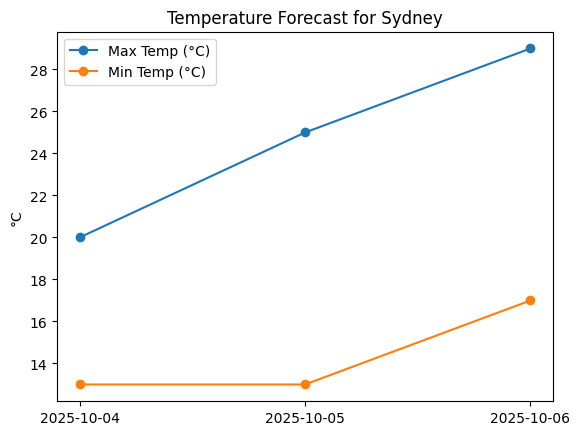


 Testing create_precipitation_visualisation()...



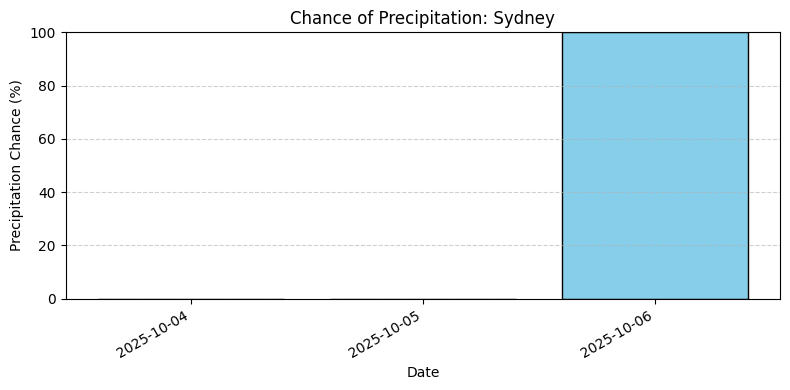


 Testing parse_weather_question()...

Parsed question data: {'location': 'Sydney', 'time': 'tomorrow', 'n_days': None, 'attribute': 'rain', 'raw': 'Will it rain in Sydney tomorrow?'}

 Testing generate_weather_response()...

Weather Advisor says: Weather for Sydney:
2025-10-05: Low chance of rain (0%). An umbrella is probably not necessary.


'## 🗂️ AI Prompting Log (Optional)\nAdd markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.\n'

In [14]:
# 🧪 Testing and Examples

# Example 1: Test weather data retrieval
print(" Testing get_weather_data()...\n")
sample_weather = get_weather_data("Sydney", forecast_days=3)
print("Weather data keys:", sample_weather.keys())
print("Current temperature:", sample_weather.get('current', {}).get('temp', 'N/A'))

# Example 2: Test temperature visualisation
print("\n Testing create_temperature_visualisation()...\n")
create_temperature_visualisation(sample_weather)

# Example 3: Test precipitation visualisation
print("\n Testing create_precipitation_visualisation()...\n")
create_precipitation_visualisation(sample_weather)

# Example 4: Test natural language parsing
print("\n Testing parse_weather_question()...\n")
parsed = parse_weather_question("Will it rain in Sydney tomorrow?")
print("Parsed question data:", parsed)

# Example 5: Test AI response generation
print("\n Testing generate_weather_response()...\n")
response = generate_weather_response(parsed, sample_weather)
print("Weather Advisor says:", response)

"""## 🗂️ AI Prompting Log (Optional)
Add markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.
"""

## 🗂️ AI Prompting Log (Optional)
Add markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.